## Make crop and aligned data from SR raw dataset

This process followed 'Zoom-learn-zoom' paper. Most of codes are also from her github.

In [2]:
from pathlib import Path
import sys
import cv2
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
from data import common
from PIL import Image

In [3]:
base = Path('dataset/SRRAW')
train = sorted(list((base / "train").glob("*")))
test = sorted(list((base / "test").glob("*")))

First, we should check the data sanyty. There are some images missing or not properly named according to its zoom level.

In [4]:
def read_focals(pathes):
    def _read_focals(base):
        if not isinstance(base, Path):
            base = Path(base)
        focals = {}
        for i in range(7):
            file_name = "{:05d}.JPG".format(i+1)
            file_path = base / file_name
            if file_path.exists():
                focal = common.readFocal_pil(file_path)
            else:
                focal = None
            focals["{:05d}".format(i+1)] = focal

        return focals

    tb = {}
    for p in pathes:
        fs = _read_focals(p)
        tb[p.stem] = fs

    return pd.DataFrame(tb)


We'll read the image focals as pandas Datafram. But some images are damged so that we can't open them. (350 - 00005, 00006, 00007)

In [5]:
train_db = read_focals(train).T
test_db = read_focals(test).T

There are total 35 image sets(33 of train, 2 of test) missing at least one image focals.

In [6]:
missing_train = train_db[train_db.isnull().any(1)]
print(len(missing_train))
missing_train

33


,00001,00002,00003,00004,00005,00006,00007
00030,157.0,101.0,70.0,49.0,35.0,24.0,NaN
00032,240.0,157.0,70.0,50.0,35.0,24.0,NaN
00033,160.0,103.0,72.0,50.0,35.0,24.0,NaN
00034,240.0,101.0,70.0,49.0,35.0,24.0,NaN
00193,240.0,157.0,101.0,49.0,34.0,24.0,NaN
00194,152.0,100.0,70.0,49.0,35.0,24.0,NaN
00195,154.0,101.0,70.0,50.0,35.0,24.0,NaN
00196,240.0,100.0,69.0,48.0,34.0,24.0,NaN
00197,240.0,103.0,69.0,50.0,35.0,24.0,NaN
00198,240.0,100.0,69.0,49.0,34.0,24.0,NaN


In [9]:
missing_test = test_db[test_db.isnull().any(1)]
print(len(missing_test))
missing_test

2


,00001,00002,00003,00004,00005,00006,00007
00022,240.0,101.0,69.0,49.0,35.0,24.0,NaN
00024,240.0,103.0,70.0,49.0,35.0,24.0,NaN


We'll move those damaged image sets to isolated folder

In [10]:
for p in missing_train.index.to_list():
    source = base / 'train' / p
    target = base / 'nan' / p
    shutil.move(source, target)

In [11]:
for p in missing_test.index.to_list():
    source = base / 'test' / p
    target = base / 'nan' / p
    shutil.move(source, target)

Then, we'll make the crop the images according to its focal ration againt reference focal length image(240mm). Following class 'Crop' is just made for crop the one imageset from SR raw data

In [6]:
from data.zoom_preprocess.data_crop import Crop
train = sorted(list((base / "train").glob("*")))
test = sorted(list((base / "test").glob("*")))

In [7]:
# test for just first one dataset
c = Crop(train[0])
c.crop_main(buffer=1., verbose=True)

Image 00001 / 00001 has focal ratio: 1.0000 
Image 00001 / 00002 has focal ratio: 1.5584 
Image 00001 / 00003 has focal ratio: 2.3301 
Image 00001 / 00004 has focal ratio: 3.4286 
Image 00001 / 00005 has focal ratio: 4.8980 
Image 00001 / 00006 has focal ratio: 6.8571 
Image 00001 / 00007 has focal ratio: 10.0000 
Set number dataset\SRRAW\train\00001 has cropped.


Let's check the results.

In [8]:
def imshows(ims, figsize=None, titles=[]):
    figsize = figsize or (len(ims) * 6, 4)
    plt.figure(figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(1, len(ims), i + 1)
        plt.imshow(im)
        if len(titles) > i:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()

In [9]:
results = Path('./data/SRRAW/train/00001/cropped').glob("*")
results = [cv2.cvtColor(cv2.imread(str(img)), cv2.COLOR_BGR2RGB) for img in results]
imshows(results)

<Figure size 0x288 with 0 Axes>

In [16]:
# for whole train data
with Pool(8) as pool:
    with tqdm(total=len(train), ncols=100, file=sys.stdout) as t:
        for c in pool.imap_unordered(Crop, train):
            c.crop_main(buffer=1)
            t.update()

100%|█████████████████████████████████████████████████████████████| 417/417 [23:04<00:00,  3.32s/it]


In [17]:
# for whole test data
with Pool(8) as pool:
    with tqdm(total=len(test), ncols=100, file=sys.stdout) as t:
        for c in pool.imap_unordered(Crop, test):
            c.crop_main(buffer=1)
            t.update()

100%|███████████████████████████████████████████████████████████████| 48/48 [02:44<00:00,  3.43s/it]


After crop, the problem is that images have different sizes. we need deal with that problem.

In [10]:
def read_img_size(dir, idx):

    def _read_img_size(path):
        img = cv2.imread(str(path))
        h, w, _ = img.shape
        return h, w

    height, width = 0, 0
    for d in dir:
        path = d / "onlycrop" / "{:05d}.JPG".format(idx)
        assert path.exists()
        h, w = _read_img_size(path)
        height += h
        width += w

    return height/len(dir), width/len(dir)

In [11]:
size = {}
for i in range(7):
    size["{:05d}".format(i+1)] = read_img_size(train, i+1)

print(size)

{'00001': (2740.681055155875, 4240.0), '00002': (1757.7601918465227, 2720.2254196642684), '00003': (1150.5515587529976, 1781.0599520383694), '00004': (791.6115107913669, 1224.3549160671462), '00005': (559.5347721822542, 864.863309352518), '00006': (393.1462829736211, 609.4292565947242), '00007': (273.24220623501196, 424.28776978417267)}


In [12]:
# we'll adjust size into these sizes
target_size = {'00001': (4240, 2740), '00002': (2720, 1758), '00003': (1780, 1150), '00004': (1224, 790), '00005': (865, 560), '00006': (610, 392), '00007': (424, 273)}

In [ ]:
def img_resize(base, target_size):
    def _img_resize(dir, target_size):
        img_paths = (dir / "onlycrop").glob("*")
    
        for path in img_paths:
            with Image.open(path) as img:
                img = img.resize(target_size[path.stem])
                img.save(path)

    for dir in base:
        _img_resize(dir, target_size)

Then, next step is alignment. The cropped images don't have same FOV, so we need to align them.
Here we'll use ECC algorithm from opencv for each imageset. This method followed 'Zoom-leanr-zoom' paper

In [18]:
# 경로 체크하기
from data.zoom_preprocess.data_align import Align

In [19]:
# To ignore deprecation warning
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [20]:
# # test for just first one dataset
a = Align(train[0])
img_t, img = a.align_main(rsz=3, iteration=500, eps=1e-6, verbose=True)

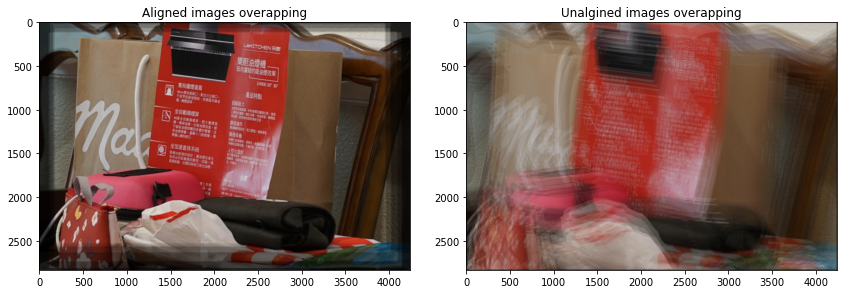

In [21]:
imshows((img_t, img), titles=["Aligned images overapping", "Unalgined images overapping"])

In [22]:
# for whole train data
with Pool(8) as pool:
    with tqdm(total=len(train), ncols=100, file=sys.stdout) as t:
        for a in pool.imap_unordered(Align, train):
            a.align_main(rsz=3, iteration=500, eps=1e-6)
            t.update()

100%|█████████████████████████████████████████████████████████████| 417/417 [27:18<00:00,  3.93s/it]


In [23]:
# for whole test data
with Pool(8) as pool:
    with tqdm(total=len(test), ncols=100, file=sys.stdout) as t:
        for a in pool.imap_unordered(Align, test):
            a.align_main(rsz=3, iteration=500, eps=1e-6)
            t.update()

100%|███████████████████████████████████████████████████████████████| 48/48 [03:16<00:00,  4.09s/it]


For train set, there are imagse having different size with its raw image. You need to check if you train from ARW to JPG

In [ ]:
n = 0
for i, t in enumerate(train):
    path = t / '00001.JPG'
    with Image.open(path) as img:
        if img.size[1] < 2832: 
            print(t.stem, end=" ")
            n += 1